In [4]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from cyecca.lie import so3, SO3Dcm, SO3Mrp, R3

# ---------------------------------------------------------------
# constants

# unit vectors
e1 = ca.SX([1, 0, 0])
e2 = ca.SX([0, 1, 0])
e3 = ca.SX([0, 0, 1])

# ---------------------------------------------------------------
# parameters

mag_decl = ca.SX.sym("mag_decl")  # magnetic declination radians
mag_incl = ca.SX.sym("mag_incl")  # magnetic inclination radians
mag_str = ca.SX.sym("mag_str")  # magnetic inclination radians
mag_std = ca.SX.sym("mag_std")  # magnetic inclination radians
dt = ca.SX.sym("dt")  # prediction period, sec

# ---------------------------------------------------------------
# state

# define vehicle state group (attitude, gyro_bias)
G = SO3Mrp * R3
x0 = param = ca.SX.sym("x0", G.n_param)
X0 = G.element(param=x0)

# frames
# n : north, east, down, in local earth frame (NED)
# b : forward, right, down in body frame (FRD)

# define vehicle state subgroups
r_nb, b = G.sub_elements(X0)  # attitude mrp, gyro bias
R_nb = r_nb.to_Matrix()  # attitude matrix

# ---------------------------------------------------------------
# state prediction

# define process noise
w = ca.SX.sym("w", 6)
W = G.algebra.element(param=w)

# this is a geodetic (assuming contant gyro), so euler prediction is exact
# this is equivalent to:
# X = X*(W*dt).exp(lie.SO3Mrp)
X1 = X0 + W * dt
r1, b1 = G.sub_elements(arg=X1)
SO3Mrp.shadow_if_necessary(r1)
X1 = G.element(param=ca.vertcat(r1.param, b1.param))
x1 = X1.param

# shadow Mrp if necessary
# x1 = SO3Mrp.shadow_param_if_necessary(X1.param)
# x1 = X.param

f_predict = ca.Function("predict", [w, x0, dt], [x1], ["w", "x0", "dt"], ["x1"])

# test it works
print("predict", f_predict([0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], 1))

# ---------------------------------------------------------------
# magnetometer correction

# calculate mag vector in body frame
# TODO: note element is rather long, maybe shorten
R_nt = so3.element(mag_decl * e3).exp(SO3Dcm)
R_tm = so3.element(-mag_incl * e2).exp(SO3Dcm)
R_nm = R_nt * R_tm

B_n = R_nm.to_Matrix() @ e1
B_b = R_nb.T @ B_n

mag_w = ca.SX.sym("mag_w", 3)

f_h_mag = ca.Function(
    "h_mag",
    [X0.param, mag_str, mag_decl, mag_incl, mag_std, mag_w],
    [B_b + mag_w * mag_std],
    ["x", "mag_str", "mag_decl", "mag_incl", "std_mag", "mag_w"],
    ["y"],
)

# test it works
print("h_mag", f_h_mag([0, 0, 0, 0, 0, 0], [1], [1], [1], [1], [0, 0, 0]))

predict [0, 0, 0, 0, 0, 0]
h_mag [1.0806, 0.841471, 0.841471]


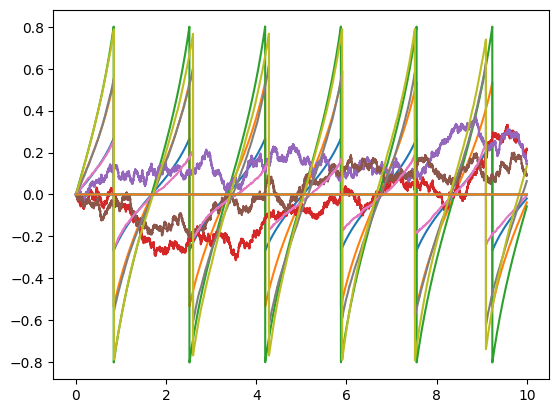

In [19]:
def simulate(t0=0, tf=10, dt=0.001):
    t = t0

    # initial estimator state
    x = np.array([0, 0, 0, 0, 0, 0])
    xh = np.array([0, 0, 0, 0, 0, 0])

    # history
    hist = {
        "x": [],
        "xh": [],
        "t": [],
    }

    # simulation loop
    for t in np.arange(start=t0, stop=tf, step=dt):
        # true angular velocity of vehicle in body frame
        omega = np.array([1, 2, 3])

        # continuous process noise using constant power assumption
        gyro_bias_noise = (0.1 / ca.sqrt(dt)) * np.random.randn(3)

        # gyro sampling noise
        gyro_noise = 1 * np.random.randn(3)

        # extract state
        gyro_bias = x[3:]

        # true lie algebra
        w = np.hstack([omega, gyro_bias_noise])

        # true propagation
        x = np.array(f_predict(w, x, dt)).reshape(-1)

        # estimated lie algebra
        wh = np.hstack([omega + gyro_noise + gyro_bias, np.zeros(3)])

        # prediction
        xh = np.array(f_predict(wh, xh, dt)).reshape(-1)

        # story history
        hist["x"].append(np.array(x).reshape(-1))
        hist["xh"].append(np.array(xh).reshape(-1))
        hist["t"].append(t)
        t += dt

    # turn history into arrays
    for k in hist.keys():
        hist[k] = np.array(hist[k])

    # plot
    plt.plot(hist["t"], hist["x"])
    plt.plot(hist["t"], hist["xh"])

    # plt.gca().set_xlim([3.12, 3.16])


simulate()